# Part One - News Classification 


In [1]:
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import re
import nltk as nlp
import math
from tqdm import tqdm
from nltk.corpus import stopwords

import tensorflow as tf 


In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import classification_report, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Attention, TimeDistributed 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

In [5]:
np.random.seed(24)

In [6]:
from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel, BertTokenizer

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
GPU is available


# Constants

In [8]:
TRAIN_PCT = 0.8
VAL_PCT = 0.1
TEST_PCT = 0.008

VOCAB_SIZE = 8000
MAXLEN = 40
EMBEDDING_DIM = 32

# Import Data

Data Source - "https://www.kaggle.com/amananandrai/ag-news-classification-dataset?select=train.csv" 

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The class ids are numbered 1-4 where:

    1 represents World,

    2 represents Sports,

    3 represents Business,

    4 represents Sci/Tech.

In [9]:
train = pd.read_csv("data/news_data/train.csv")

test = pd.read_csv("data/news_data/test.csv")

In [10]:
train.head(10)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [11]:
train.shape, test.shape

((120000, 3), (7600, 3))

In [12]:
train = train.rename(columns= {"Class Index": "labels", "Title": "title", "Description": "text"})

In [13]:
test = test.rename(columns= {"Class Index": "labels", "Title": "title", "Description": "text"})

# Data Analysis

In [14]:
train.labels.value_counts(), test.labels.value_counts()

(1    30000
 2    30000
 3    30000
 4    30000
 Name: labels, dtype: int64,
 4    1900
 1    1900
 2    1900
 3    1900
 Name: labels, dtype: int64)

We have prefectly balanced datasets so there is no need for under-/oversampling.

I'm going to split the train data into train and validation datasets so i can inspect both of them

In [15]:
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for (label, group_texts) in train.groupby('labels'):
    
    group_texts = group_texts.sample(len(group_texts))  ## shuffle the data for each group
    
    train_data_end_index = int(len(group_texts) * TRAIN_PCT)
    val_data_end_index = train_data_end_index + int(len(group_texts) * VAL_PCT)
    
    
    train_data_in_group = group_texts[:train_data_end_index]
    val_data_in_group = group_texts[train_data_end_index:val_data_end_index]
    test_data_in_group = group_texts[val_data_end_index :]
    
    print(len(train_data_in_group), len(val_data_in_group), len(test_data_in_group))
    
    train_data = train_data.append(train_data_in_group)
    val_data = val_data.append(val_data_in_group)
    test_data = test_data.append(test_data_in_group)

24000 3000 3000
24000 3000 3000
24000 3000 3000
24000 3000 3000


In [16]:
test_data = test_data.append(test)

In [17]:
print(f"Train data shape: {train_data.shape}, Test data shape {test_data.shape}, Validiation data shape: {val_data.shape}")

Train data shape: (96000, 3), Test data shape (19600, 3), Validiation data shape: (12000, 3)


In [18]:
train_data.labels = train_data['labels'].apply(lambda x: x-1)
val_data.labels = val_data['labels'].apply(lambda x: x-1)
test_data.labels = test_data['labels'].apply(lambda x: x-1)

In [19]:
train_data.to_csv("output_datasets/news_output/train_data.csv", index=False)
val_data.to_csv("output_datasets/news_output/val_data.csv", index=False)
test_data.to_csv("output_datasets/news_output/test_data.csv", index=False)

The class ids now are numbered 0-3 where:

    0 represents World,

    1 represents Sports,

    2 represents Business,

    3 represents Sci/Tech.

Now we have created validation data and added more data in the test data as well

Text(0.5, 1.0, 'Test data')

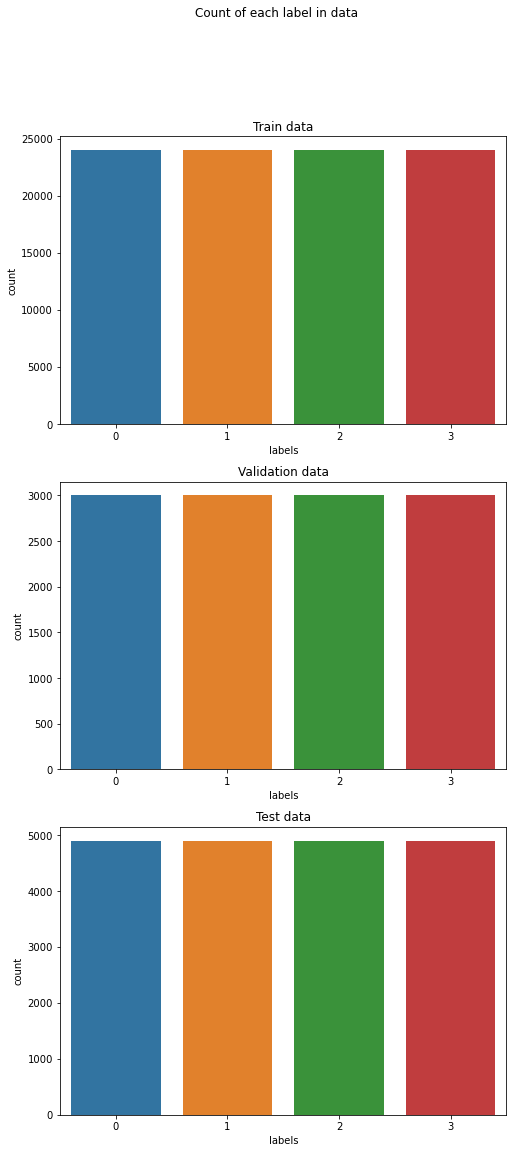

In [20]:
fig, axes =plt.subplots(3,1,figsize=(8,18))

fig.suptitle('Count of each label in data')

sns.countplot(ax=axes[0], x = train_data.labels)
axes[0].set_title('Train data')

sns.countplot(ax=axes[1], x = val_data.labels)
axes[1].set_title('Validation data')

sns.countplot(ax=axes[2], x = test_data.labels)
axes[2].set_title("Test data")

### Length of each sentance

In [21]:
nums_of_tokens_train = []
for text in train_data.text:
    nums_of_tokens_train.append(len(re.findall('[a-z-]+', text, flags=re.I)))

In [22]:
nums_of_tokens_val = []
for text in val_data.text:
    nums_of_tokens_val.append(len(re.findall('[a-z-]+', text, flags=re.I)))

In [23]:
nums_of_tokens_test = []
for text in test_data.text:
    nums_of_tokens_test.append(len(re.findall('[a-z-]+', text, flags=re.I)))

C:\Users\levsk\.conda\envs\base-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test data')

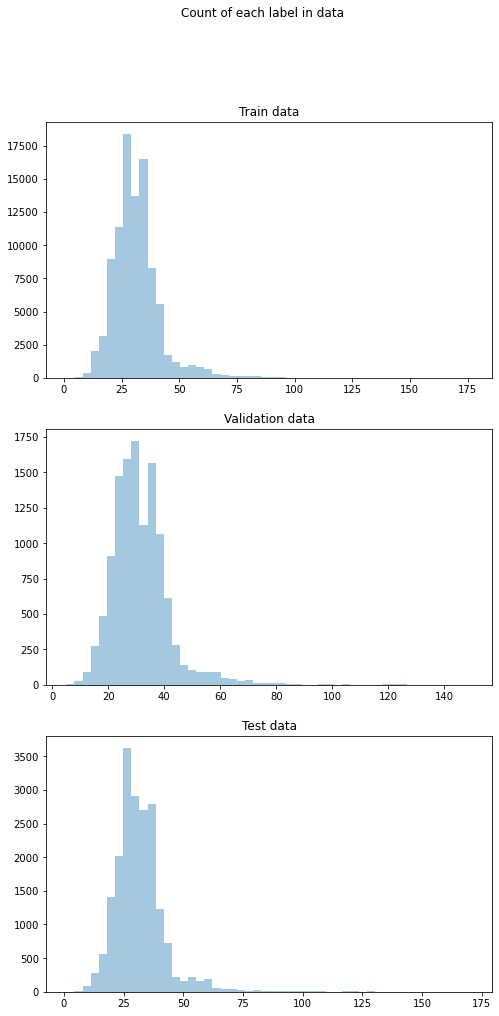

In [24]:
fig, axes = plt.subplots(3,1,figsize=(8,16))

fig.suptitle('Count of each label in data')

sns.distplot(ax=axes[0], x = [len(re.findall('[a-z-]+', text, flags=re.I)) for text in train_data.text], kde=False, rug=False)
axes[0].set_title('Train data')

sns.distplot(ax=axes[1], x = [len(re.findall('[a-z-]+', text, flags=re.I)) for text in val_data.text], kde=False, rug=False)
axes[1].set_title('Validation data')

sns.distplot(ax=axes[2], x = [len(re.findall('[a-z-]+', text, flags=re.I)) for text in test_data.text], kde=False, rug=False)
axes[2].set_title("Test data")

Here we can see that the majority of each document contains within 20 - 40 tokens. That is good because we dont have really long seqences of words.

This is only by the text column. I didn't include the title in this. 

Let's see some news...

In [25]:
for text in train_data.text[1:10]:
    print(f"{text}\n")

Reuters - When India play Pakistan, it is a classic hockey match, their historic rivalry sucking in the whole stadium.

Secretary of State Colin L. Powell said yesterday that Brazil is a  quot;serious quot; and  quot;solid quot; candidate for a permanent seat in an expanded UN Security Council, although 

Russian President Vladimir Putin says his country is developing a new type of nuclear missile. Mr. Putin spoke at an annual meeting of the armed forces #39; senior leadership.

The British and Iraqi governments said they would not bow to the demands of militants threatening to kill a British hostage, despite tearful pleas from the captive and his family.

Reuters - Congo's government spokesman denied\Tuesday that rival army factions were fighting each other in\the east of the country and insisted the clashes were between\Congolese and Rwandan forces.

AFP - The dollar dipped amid concerns about the US position with the rest of the world following data showing a record current account 

We can see that these documents are not cleaned neither stopwords removed. But for now I'am going to keep them and just Tokenize them.

### Word Clouds

In [26]:
map = {
    0: "World",
    1: "Sport",
    2: "Business",
    3: "Tech"
}

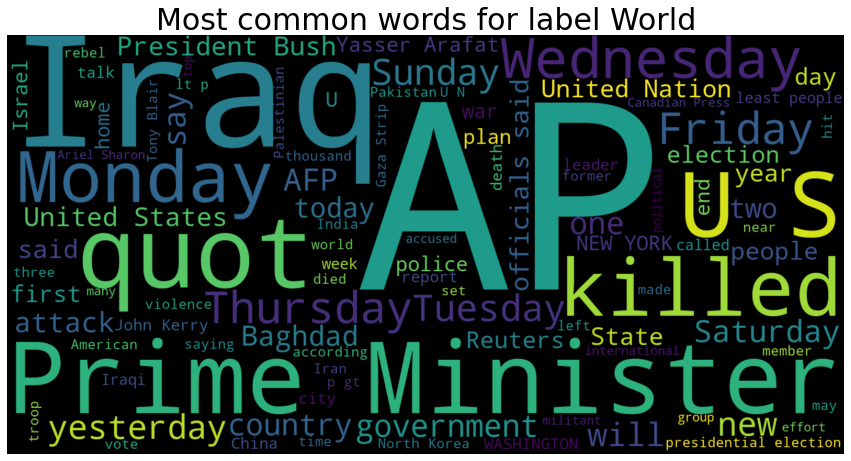

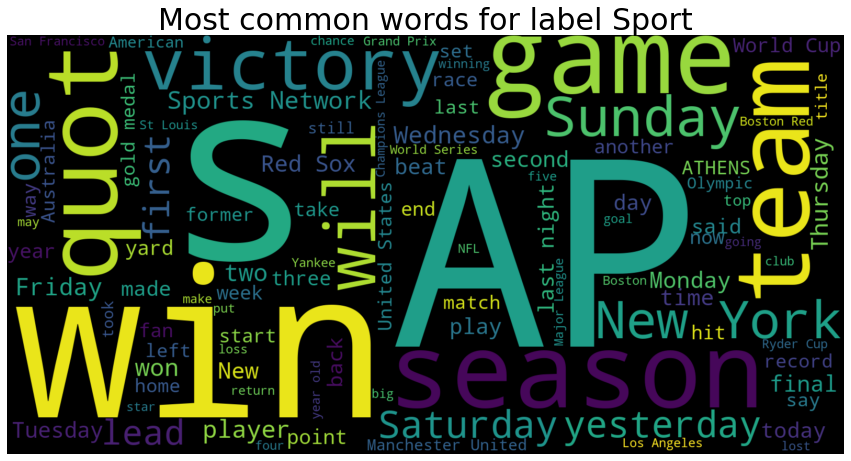

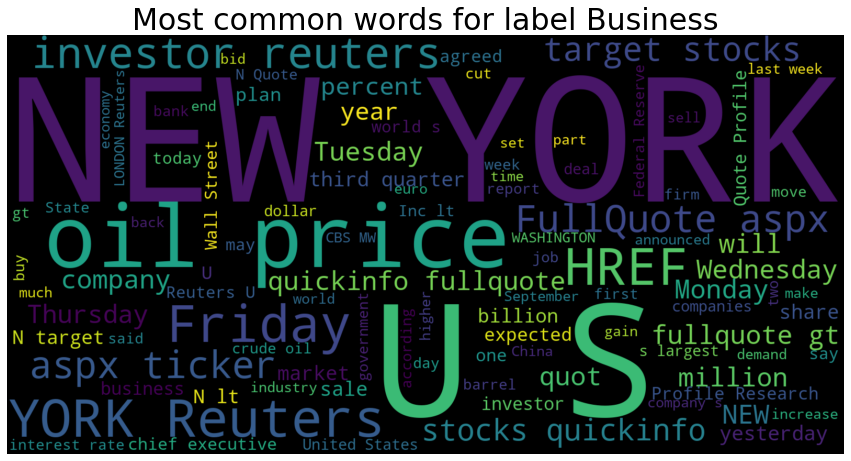

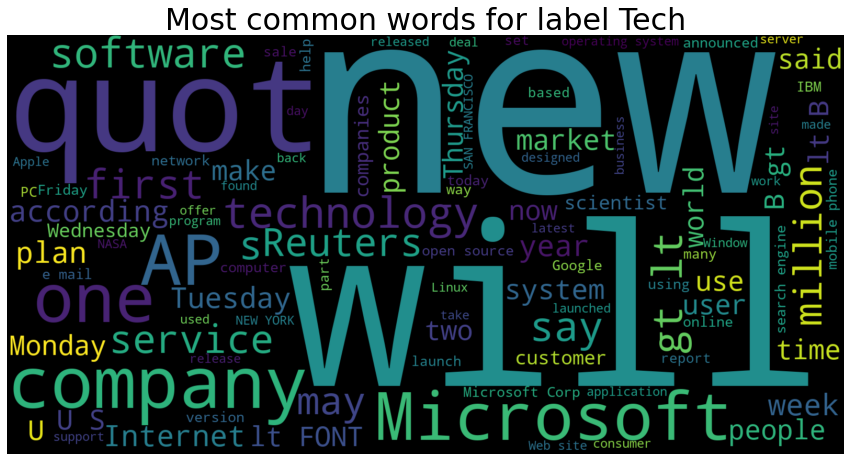

In [27]:
for label in train_data.labels.unique():
    # Start with one review:
    generic_words = " ".join(train_data[train_data.labels == label].text)

    plt.figure(figsize  = (15,10))
    # Create and generate a word cloud image:
    wordcloud_ALL = WordCloud(max_font_size=500, max_words=100, background_color="black", width = 1600 , height = 800,
                             stopwords=STOPWORDS).generate(generic_words)
    plt.imshow(wordcloud_ALL, interpolation='bilinear')
    plt.title(f'Most common words for label {map.get(label)}', fontsize=30)
    plt.axis('off')
    plt.show()

We see that these different classes have different words which shows us that the text is actually by topic and is not that biased towards one class

# Neural Network Part 1 - Classification

We have classical classification problem and I will build one basic RNN network and I will use the power of the Transformers

## I.Text Preprocessing 

In [28]:
sample = train_data.sample(28)

In [29]:
sample.head(5)

,labels,title,text
79111,2,Unleash the dragon,St George Bank Limited (SGB) today advised it ...
88610,3,European craft to probe #39;moon colonies #39;,A tiny craft powered by Star Trek #39; technol...
53820,3,Mars Rovers Planners Plot Crater 'Escape' (AP),AP - NASA's Mars rovers don't seem to be weari...
116767,1,"NHL: Impasse continues as league, union pass o...","There is no end in sight for the lockout, whic..."
9406,3,Connexion by Boeing partners with iPass,The agreement with Connexion by Boeing will gi...


### 1) Basic Tensorflow Tokenization

Here I'm going to Tekenize the text and get sample of it so i can train real quick in the neural network.

In [30]:
sample.labels.value_counts()

2    9
1    7
3    7
0    5
Name: labels, dtype: int64

In [31]:
tokenizer = Tokenizer(num_words=8000, lower=True)

In [32]:
sample_token = tokenizer.fit_on_texts(sample.text)

In [33]:
sample_token = tokenizer.texts_to_sequences(sample.text)

This is our little vocabulary with sequences of words . We have unique value for each unique word.

We will get the max length for the sequence and try padding to that number.

In [34]:
# maxlen = max([len(x) for x in sample_token])

C:\Users\levsk\.conda\envs\base-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

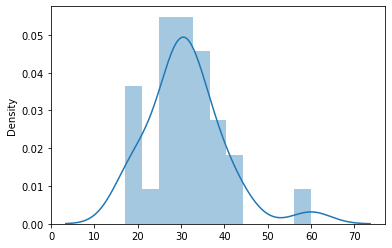

In [35]:
sns.distplot([len(sen) for sen in sample_token], kde=True, rug=False)

With this plot I can see that the majority of the sentances are with length of 40 tokens. So for maxlen I will choose 40.

In [36]:
sample_padded = pad_sequences(sample_token, padding="post", truncating="post", maxlen = MAXLEN)

In [37]:
sample_padded

array([[100, 101, 102, ...,   0,   0,   0],
       [  3, 115, 116, ...,   0,   0,   0],
       [129, 130, 131, ..., 148,   2, 149],
       ...,
       [ 40, 524,  20, ...,   0,   0,   0],
       [  1, 536, 537, ...,   0,   0,   0],
       [  9, 552, 553, ...,   0,   0,   0]])

In [38]:
tokenizer.fit_on_texts(train_data.text.values)

# Create and Fit tokenizer
X_train = tokenizer.texts_to_sequences(train_data.text.values)
X_val = tokenizer.texts_to_sequences(val_data.text.values)
X_test = tokenizer.texts_to_sequences(test_data.text.values)


# Pad data
X_train_padded = pad_sequences(X_train, padding="post", truncating="post", maxlen = MAXLEN)
X_val_padded = pad_sequences(X_val, padding="post", truncating="post", maxlen = MAXLEN)
X_test_padded = pad_sequences(X_test, padding="post", truncating="post", maxlen = MAXLEN)

### 2) DistilBert Tekenization

Here i will use pre-trained tokenizer who returns 3 types of tokenizer output

In [39]:
distil_bert = 'distilbert-base-uncased'

In [40]:
distil_bert = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=MAXLEN, pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAXLEN, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [41]:
X_bert_train = tokenize(train_data.text, tokenizer) 

  0%|          | 0/96000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\levsk\.conda\envs\base-gpu\lib\site-packages\transformers-4.2.2-py3.8.egg\transformers\tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
100%|██████████| 96000/96000 [01

In [42]:
X_bert_val = tokenize(val_data.text, tokenizer)

100%|██████████| 12000/12000 [00:11<00:00, 1067.11it/s]


In [43]:
X_bert_test = tokenize(test_data.text, tokenizer)

100%|██████████| 19600/19600 [00:18<00:00, 1072.33it/s]


In [44]:
X_bert_train

(array([[  101,  1996, 25941, ...,     0,     0,     0],
        [  101, 26665,  1011, ...,     0,     0,     0],
        [  101,  3187,  1997, ...,  4895,  3036,   102],
        ...,
        [  101, 26665,  1011, ...,     0,     0,     0],
        [  101,  1996,  2326, ...,     0,     0,     0],
        [  101,  6603,  2065, ...,  7513,  1998,   102]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [45]:
train_input_ids = X_bert_train[0]
train_attention_mask = X_bert_train[1]

val_input_ids = X_bert_val[0]
val_attention_mask = X_bert_val[1]

test_input_ids = X_bert_test[0]
test_attention_mask = X_bert_test[1]


After Bert tokenzization we have output data with 3 categories.

    1) The input ids — for classification problem, two inputs sentences should be tokenized and concatenated together. We see a lot of [101] and in the end [102]. Those are special BERT tokens for [CLS] and [SEP]

    2) The input masks — allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input ids, and contains 1 anywhere the the input ids is not padding.

    3) The input types — also has the same shape as the input ids, but inside the non-padded region, it contains 0 or 1 indicating which sentence the token is a part of.
    
We are going to use only first two because we don't need 3rd for DistilBert

## II. Building Model

So for text modeling I have to use Recurrent Neural Networks. They allow previous outputs to be used as inputs while having hidden states. We can keep track of the words being used for each timestep. Model size does not increase with the size of the input but there is a problem with longer sentances called vanishing/exploding gradients. Also they have difficulty accessing information from long time ago.

First I am going to inspect how our sample data is performing with basic RNN and then I will try Encoder part of Transformer with BiDirectional LSTM layer.

### 1) RNN

In [46]:
tf.keras.backend.clear_session()

In [47]:
rnn_model = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAXLEN),
    SimpleRNN(64, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    GlobalAveragePooling1D(),
    Dense(4, activation='softmax') ## 4 classes
])

In [48]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 32)            256000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 40, 64)            6208      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40, 32)            3104      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 265,444
Trainable params: 265,444
Non-trainable params: 0
_________________________________________________________________


In [49]:
rnn_model.compile(optimizer = "rmsprop", loss = SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [50]:
rnn_model.fit(x = sample_padded, y = sample.labels.values, epochs = 10)

Epoch 1/10
1/1 [==============================] - 0s 1000us/step - loss: 1.3893 - accuracy: 0.2857
Epoch 2/10
1/1 [==============================] - 0s 1000us/step - loss: 1.2638 - accuracy: 0.5357
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0737 - accuracy: 0.5714
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0062 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.8937 - accuracy: 0.5714
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.8497 - accuracy: 0.7143
Epoch 7/10
1/1 [==============================] - 0s 999us/step - loss: 0.7800 - accuracy: 0.7857
Epoch 8/10
1/1 [==============================] - 0s 998us/step - loss: 0.7662 - accuracy: 0.7500
Epoch 9/10
1/1 [==============================] - 0s 999us/step - loss: 0.7401 - accuracy: 0.6429
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 0.6924 - accuracy: 0.7857


We can see that for 10 epochs the loss is going down while the accuracy is rising.

Now lets feed this architecture with all of the data.

In [51]:
rnn_model_big = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAXLEN),
    SimpleRNN(32, return_sequences = True),
    Dropout(0.2),
    SimpleRNN(12),
    Dropout(0.1),
    Dense(4, activation='softmax')
])

In [52]:
rnn_model_big.compile(optimizer = RMSprop(learning_rate=(0.001)), loss = SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [53]:
rnn_history = rnn_model_big.fit(x = X_train_padded, y = train_data.labels.values,
                epochs = 6,
                callbacks = [TensorBoard(log_dir = "logs_rnn_basic"), 
                             EarlyStopping(patience = 2, restore_best_weights=True)],
                validation_data=(X_val_padded, val_data.labels.values),
                batch_size = 1024)


Epoch 1/6
 1/94 [..............................] - ETA: 0s - loss: 1.4855 - accuracy: 0.2373WARNING:tensorflow:From C:\Users\levsk\.conda\envs\base-gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
94/94 [==============================] - 6s 61ms/step - loss: 0.8766 - accuracy: 0.6524 - val_loss: 0.5655 - val_accuracy: 0.8388
Epoch 2/6
94/94 [==============================] - 5s 54ms/step - loss: 0.5425 - accuracy: 0.8379 - val_loss: 0.4748 - val_accuracy: 0.8658
Epoch 3/6
94/94 [==============================] - 5s 54ms/step - loss: 0.4402 - accuracy: 0.8748 - val_loss: 0.4031 - val_accuracy: 0.8792
Epoch 4/6
94/94 [==============================] - 5s 55ms/step - loss: 0.3809 - accuracy: 0.8906 - val_loss: 0.3714 - val_accuracy: 0.8878
Epoch 5/6
94/94 [==============================] - 5s 54ms/step -

In [54]:
tf.keras.backend.clear_session()

I used 6 epochs because I know that the best I can get with this type of data is nearly 90 % accuracy.

#### Learning Rate Scheduler

The following scheduling function exponentially decreases the learning rate over time from the starting point. Mathematically it can be represented as where is the initial learning rate value, is a decay hyperparameter and is the epoch/iteration number.

In [55]:
lr_reduce = ReduceLROnPlateau(monitor="val_loss", patiece = 3, verbose = 1)

In [56]:
rnn_model_lr = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAXLEN),
    SimpleRNN(64, return_sequences = True),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.1),
    Dense(4, activation='softmax')
])

In [57]:
rnn_model_lr.compile(optimizer = RMSprop(learning_rate = 0.001), loss = SparseCategoricalCrossentropy(), metrics = ['accuracy'])

In [58]:
rnn_model_lr.load_weights("Part_one/saved_models/rnn_model_lr.h5")

In [ ]:
rnn_history_lr_sch = rnn_model_lr.fit(x = X_train_padded, y = train_data.labels.values,
                epochs = 6,
                callbacks = [TensorBoard(log_dir = "logs_rnn_lr_scheduler"),
                            lr_reduce,
                            ModelCheckpoint(
                                        filepath='lr_reducer_weights.h5',
                                        monitor='val_accuracy', 
                                        mode='max', 
                                        save_best_only=True,
                                        save_weights_only=True,
                                        verbose=1)],
                validation_data=(X_val_padded, val_data.labels.values),
                batch_size = 1024)

Epoch 1/6
94/94 [==============================] - 12s 111ms/step - loss: 1.1532 - accuracy: 0.4624 - val_loss: 0.5266 - val_accuracy: 0.8078

Epoch 00001: val_accuracy improved from -inf to 0.80783, saving model to lr_reducer_weights.h5
Epoch 2/6
94/94 [==============================] - 10s 106ms/step - loss: 0.4730 - accuracy: 0.8388 - val_loss: 0.4022 - val_accuracy: 0.8633

Epoch 00002: val_accuracy improved from 0.80783 to 0.86333, saving model to lr_reducer_weights.h5
Epoch 3/6
94/94 [==============================] - 10s 104ms/step - loss: 0.3689 - accuracy: 0.8796 - val_loss: 0.4718 - val_accuracy: 0.8488

Epoch 00003: val_accuracy did not improve from 0.86333
Epoch 4/6
94/94 [==============================] - 10s 102ms/step - loss: 0.3207 - accuracy: 0.8956 - val_loss: 0.3607 - val_accuracy: 0.8821

Epoch 00004: val_accuracy improved from 0.86333 to 0.88208, saving model to lr_reducer_weights.h5
Epoch 5/6
94/94 [==============================] - 10s 104ms/step - loss: 0.2702 -

In [ ]:
rnn_history_lr_sch.history

{'accuracy': [0.617229163646698,
  0.843500018119812,
  0.877916693687439,
  0.895312488079071,
  0.9111979007720947,
  0.9204583168029785],
 'loss': [0.9035103917121887,
  0.46015799045562744,
  0.3676568567752838,
  0.31787919998168945,
  0.2724083364009857,
  0.24141451716423035],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_accuracy': [0.8078333139419556,
  0.8633333444595337,
  0.8488333225250244,
  0.8820833563804626,
  0.8813333511352539,
  0.8845000267028809],
 'val_loss': [0.5266156792640686,
  0.4022011458873749,
  0.471763014793396,
  0.36070573329925537,
  0.381722629070282,
  0.3669511675834656]}

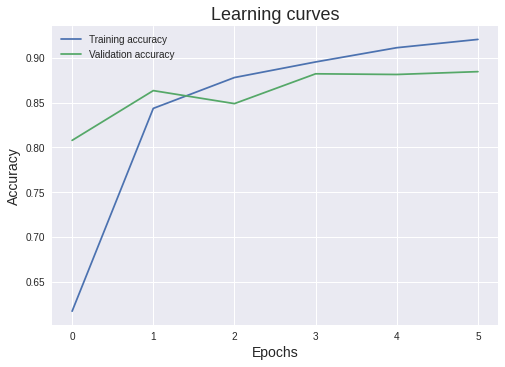

In [ ]:
plt.style.use('seaborn')
plt.plot(rnn_history_lr_sch.history['accuracy'], label = 'Training accuracy')
plt.plot(rnn_history_lr_sch.history['val_accuracy'], label = 'Validation accuracy')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Learning curves', fontsize = 18)
plt.legend()

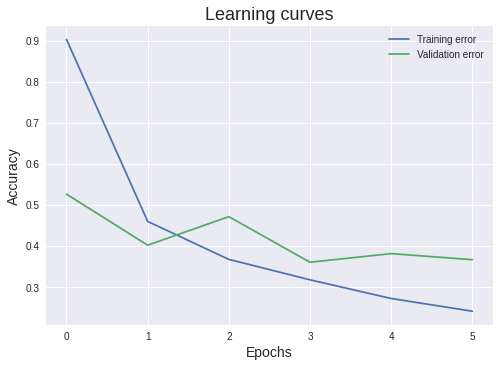

In [ ]:
plt.style.use('seaborn')
plt.plot(rnn_history_lr_sch.history['loss'], label = 'Training error')
plt.plot(rnn_history_lr_sch.history['val_loss'], label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Learning curves', fontsize = 18)
plt.legend()

So the best values for validation acc were in the 4rd epoch so out ModelCheckpoin saved the weights of the model. And the model is not overfitting.

For better implementation for the lr scheduler is when we train for more epochs...

In [59]:
rnn_model_lr.evaluate(X_test_padded, test_data.labels.values)

613/613 [==============================] - 4s 7ms/step - loss: 0.3673 - accuracy: 0.8819


[0.36727163195610046, 0.8819387555122375]

In [ ]:
rnn_model_lr.save("saved_models/rnn_model_lr")
rnn_model_lr.save_weights("saved_models/rnn_model_lr.h5")

INFO:tensorflow:Assets written to: saved_models/rnn_model_lr/assets


### 2) DistilBERT transformer

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.
BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

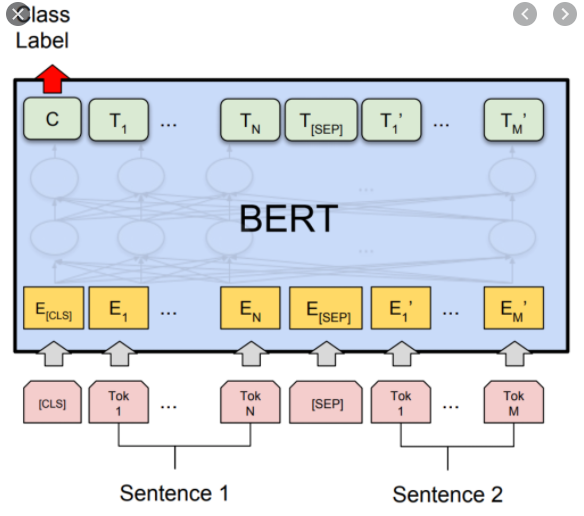

DistilBert is smaller, faser, cheaper version of Bert. It has 40% less parameters and runs 60% faster while preserving over 95% of BERT's performances.

I this project I will be using this version.

#### Build DistilBert

In [82]:
def create_bert():    
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config=config)

    input_ids_in = tf.keras.layers.Input(shape=(MAXLEN,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(MAXLEN,), name='masked_token', dtype='int32') 

    embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(4, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    return model

In [83]:
bert_model = create_bert()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cach

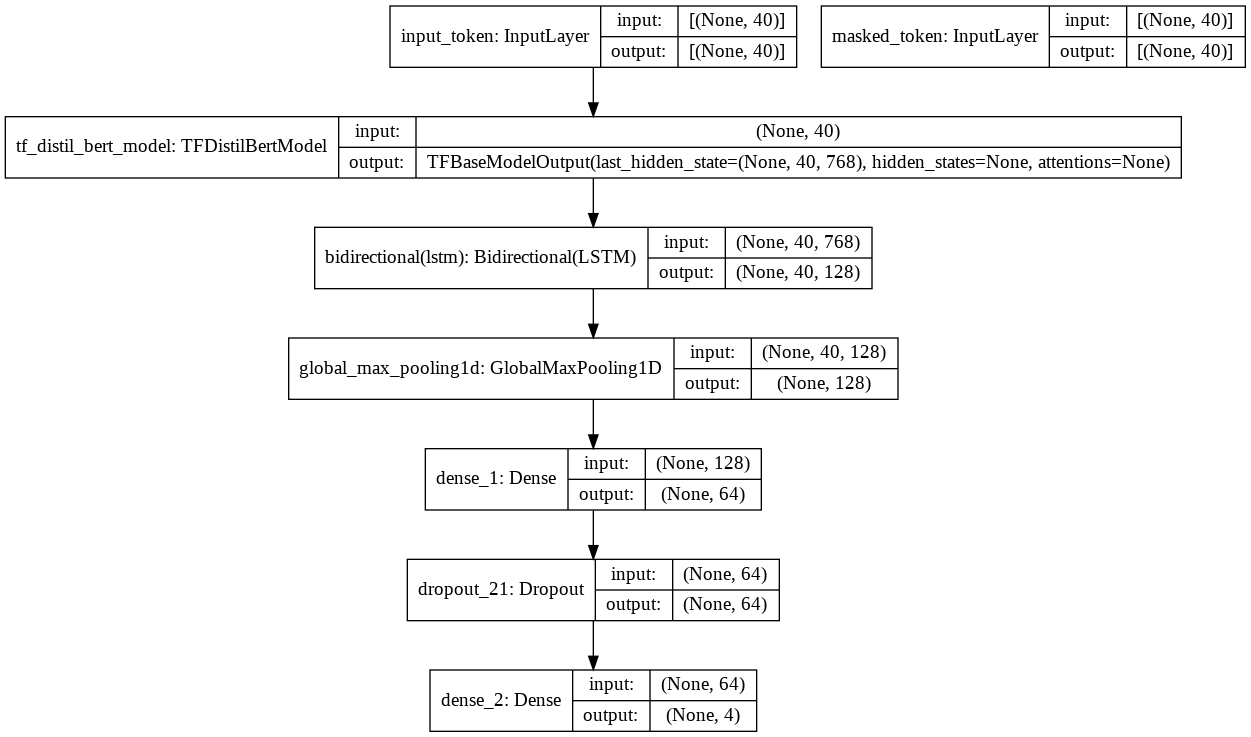

In [ ]:
plot_model(bert_model, show_shapes=True)

In [84]:
bert_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 40)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40, 128)      426496      tf_distil_bert_model_1

This model as we see has 2 inputs from tokenized text: (input_tokens, masked_tokens)
Bert Embedding layer has 2 oputputs: 

      1)pooled_output to represent each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.

      2)sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.
      
We are taking only the second output.

For training parameters we will use only after Bert layer ones because of computation power :/.
We make some regularization with Dropout and Global Max Pooling and final 4 nodes Dense layer for the classification

In [85]:
bert_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])


In [86]:
bert_history = bert_model.fit([train_input_ids, train_attention_mask], train_data.labels.values, batch_size=1024,
                         validation_data=([val_input_ids, val_attention_mask], val_data.labels.values),
                          epochs=15,
                         callbacks=[EarlyStopping(
                                        monitor='val_accuracy',
                                        patience=3,
                                        restore_best_weights=True),
                                    ModelCheckpoint(
                                        filepath='bert_weights.h5',
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_best_only=True,
                                        save_weights_only=True)
                                   ])

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/15


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


94/94 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8617

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


94/94 [==============================] - 149s 2s/step - loss: 0.3862 - accuracy: 0.8617 - val_loss: 0.2672 - val_accuracy: 0.9054
Epoch 2/15
94/94 [==============================] - 147s 2s/step - loss: 0.2717 - accuracy: 0.9054 - val_loss: 0.2389 - val_accuracy: 0.9111
Epoch 3/15
94/94 [==============================] - 147s 2s/step - loss: 0.2489 - accuracy: 0.9116 - val_loss: 0.2303 - val_accuracy: 0.9158
Epoch 4/15
94/94 [==============================] - 147s 2s/step - loss: 0.2325 - accuracy: 0.9168 - val_loss: 0.2244 - val_accuracy: 0.9183
Epoch 5/15
94/94 [==============================] - 148s 2s/step - loss: 0.2181 - accuracy: 0.9226 - val_loss: 0.2222 - val_accuracy: 0.9193
Epoch 6/15
94/94 [==============================] - 145s 2s/step - loss: 0.2097 - accuracy: 0.9249 - val_loss: 0.2223 - val_accuracy: 0.9184
Epoch 7/15
94/94 [==============================] - 146s 2s/step - loss: 0.2013 - accuracy: 0.9261 - val_loss: 0.2231 - val_accuracy: 0.9222
Epoch 8/15
94/94 [======

In [89]:
bert_model.save_weights("Part_one/saved_models/bert_model.h5")

12th epoch is the best accuracy and the model is not overfitting that much either.

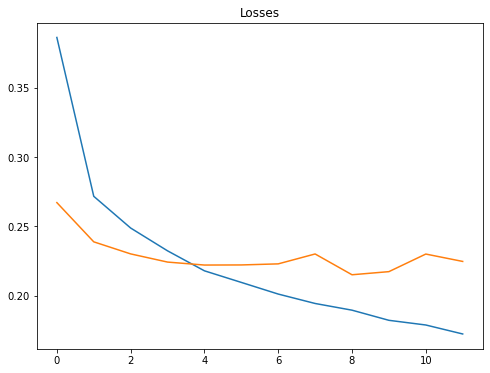

In [90]:
plt.figure(figsize=(8,6))
plt.title("Losses")
plt.plot(bert_history.history['loss'])
plt.plot(bert_history.history['val_loss'])
plt.show()

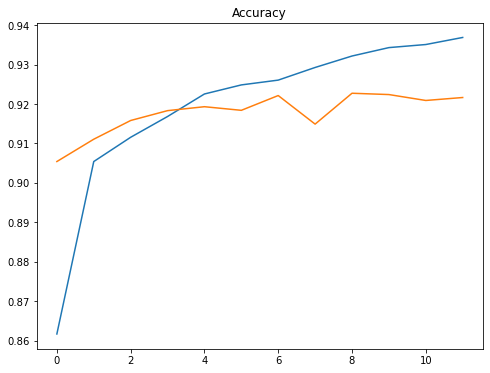

In [91]:
plt.figure(figsize=(8,6))
plt.title("Accuracy")
plt.plot(bert_history.history['accuracy'])
plt.plot(bert_history.history['val_accuracy'])
plt.show()

We had really slow improvement that's because the learning rate or vanishing gradients problem.

We are saving the weights from the best epoch based on ModelCheckpoint

In [92]:
bert_model.evaluate([test_input_ids, test_attention_mask], test_data.labels.values)

613/613 [==============================] - 35s 58ms/step - loss: 0.2223 - accuracy: 0.9218


[0.22233843803405762, 0.9217857122421265]

### Let's test the models

Using Classification Matrix we are going to see on the test set predicted classes

In [93]:
labels_dict = {
    "World": 0,
    "Sport": 1,
    "Business": 2,
    "Tech": 3
}

#### RNN model predictions

In [94]:
preds = [np.argmax(i) for i in rnn_model_lr.predict(X_test_padded)]
cm  = confusion_matrix(test_data.labels.values, preds)

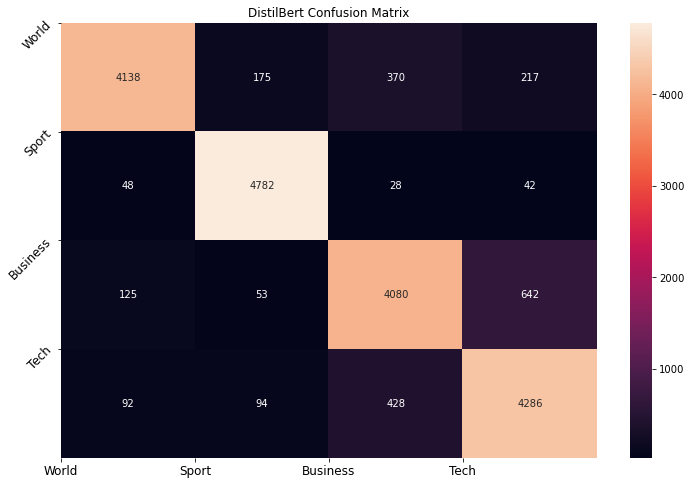

In [95]:
plt.figure(figsize=(12,8))
plt.title("DistilBert Confusion Matrix")
sns.heatmap(cm,  annot=True, fmt="d")
plt.xticks(range(4),labels_dict, fontsize=12)
plt.yticks(rotation = 45)
plt.yticks(range(4), labels_dict, fontsize=12)
plt.show()

We see really nice results for the true predictions but we can see little bit more False Positives between Science-Technology and Buisness News, even though it's really hard to tell even with a human prespective. In most cases in Tech news, they are articles with money, investments, GDP and etc. (which is in between)

#### BERT Model predictions

In [96]:
preds = [np.argmax(i) for i in bert_model.predict([test_input_ids, test_attention_mask])]
cm  = confusion_matrix(test_data.labels.values, preds)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


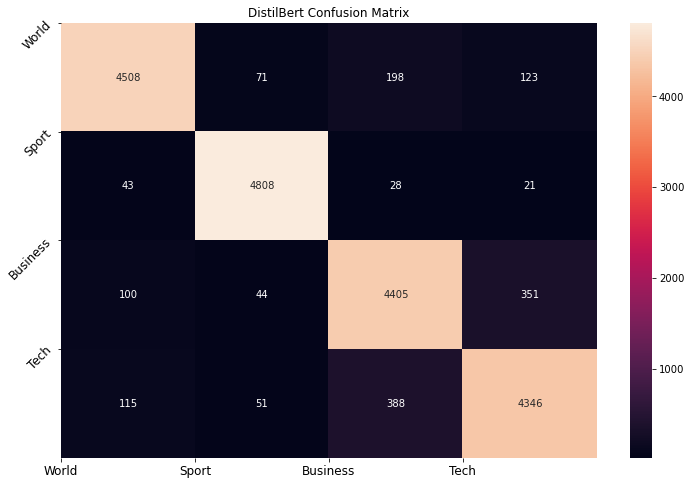

In [97]:
plt.figure(figsize=(12,8))
plt.title("DistilBert Confusion Matrix")
sns.heatmap(cm,  annot=True, fmt="d")
plt.xticks(range(4), labels_dict, fontsize=12)
plt.yticks(rotation = 45)
plt.yticks(range(4), labels_dict, fontsize=12)
plt.show()

We can see with that in BERT model the accuracy on the training set is going up but val_accuracy is staying around 92% wich is showing slow overfitting. We got better performence but the training is slow... 

Wold news, Business News and Tech are kinda related. Even human can missclassify them but despite that I am overwhelmed!
The pretrained model of bert is good classifier and works pretty well.
The final state if the given document is certain class is comming from the [CLS] token which we get the values from!

Sport news are most destinguishable also with the world.